### Forecast de demanda: Facturapp

#### ✅ XGBoost

##### Datos

In [1]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [2]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [3]:
# Lista de códigos de producto que quieres filtrar
codigos_producto = ['60']

# Filtrar el DataFrame original para que solo incluya las filas con los códigos de producto especificados
ventas_filtradas_df = ventas_df[ventas_df['codigo_producto'].isin(codigos_producto)]

# Crear la tabla agregada con los datos filtrados
tabla_agrupada = ventas_filtradas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Pivotear las ventas de cada código de producto
ventas_por_producto = ventas_filtradas_df.pivot_table(index='fecha_venta', columns='codigo_producto', values='cantidad_ventas_producto', aggfunc='sum', fill_value=0)

# Renombrar las columnas con un prefijo para que coincida con tu formato
ventas_por_producto.columns = [f'codigo_producto_{col}' for col in ventas_por_producto.columns]

# Unir las tablas
df_xgboost = pd.merge(tabla_agrupada, ventas_por_producto, on='fecha_venta', how='left')

df_xgboost = df_xgboost[['fecha_venta', 'cantidad_ventas_producto']]

df_xgboost.head()

,fecha_venta,cantidad_ventas_producto
0,2022-04-18,1.0
1,2022-04-20,5.0
2,2022-04-21,2.0
3,2022-04-22,7.0
4,2022-04-23,6.0


#### XGBoost sin optimización

Mean Squared Error (MSE): 19.83482483361308
Root Mean Squared Error (RMSE): 4.453630522799695


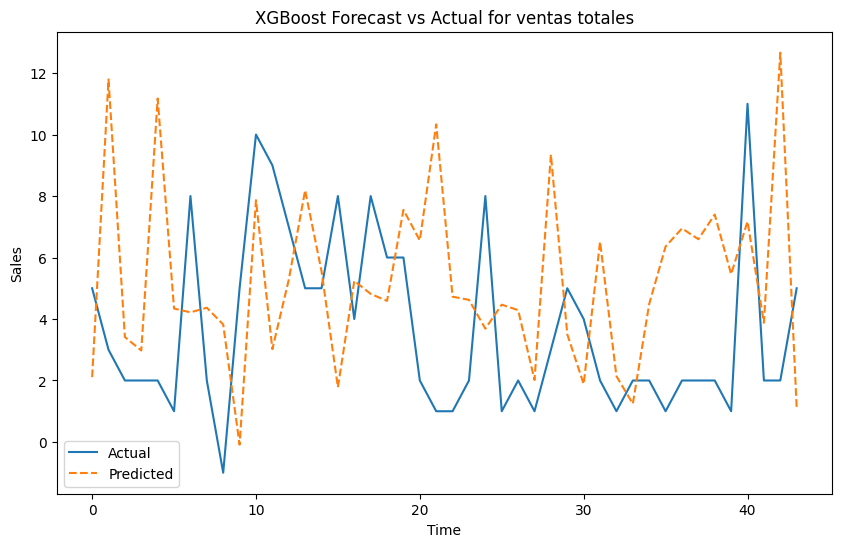

,actual,predicted
180,5.0,2.108526
181,3.0,11.794744
182,2.0,3.414363
183,2.0,2.974896
184,2.0,11.172670


In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Crear características de lag para XGBoost
def create_lag_features(df, lag=3):
    df_lag = pd.DataFrame()
    for i in range(1, lag+1):
        df_lag[f'lag_{i}'] = df.shift(i)
    df_lag['target'] = df
    df_lag.dropna(inplace=True)
    return df_lag

# Crear características de lag
df_lagged = create_lag_features(df_xgboost['cantidad_ventas_producto'], lag=5)

# Separar características y etiquetas
X = df_lagged.drop('target', axis=1)
y = df_lagged['target']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Crear y entrenar el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostrar métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Crear un DataFrame para comparar los valores reales y predichos
df_forecast = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_forecast['actual'].values, label='Actual')
plt.plot(df_forecast['predicted'].values, label='Predicted', linestyle='--')
plt.title(f'XGBoost Forecast vs Actual for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Mostrar las primeras filas de las predicciones comparadas
df_forecast.head(5)

#### XGBoost con optimización

##### Opción 1

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8}
Mean Squared Error (MSE): 15.166302513068702
Root Mean Squared Error (RMSE): 3.8943937285627275


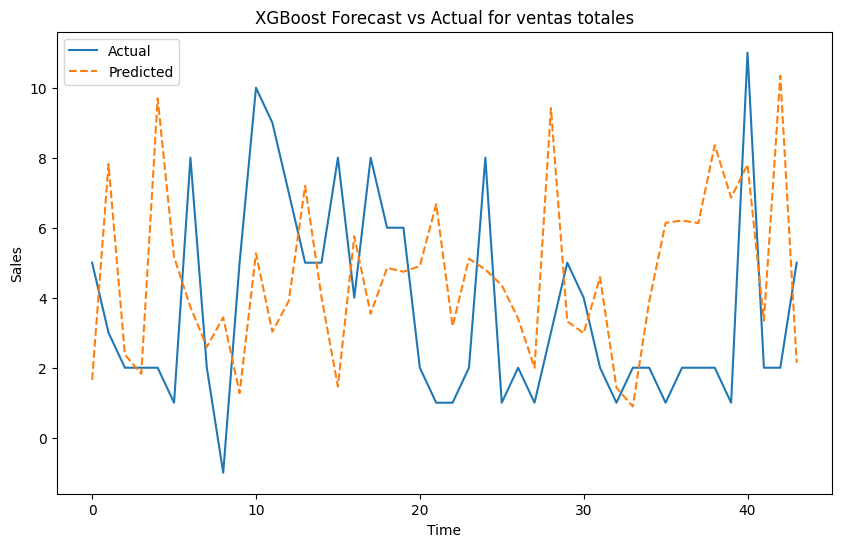

,actual,predicted
180,5.0,1.655049
181,3.0,7.820055
182,2.0,2.374523
183,2.0,1.826264
184,2.0,9.694556


In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Crear características de lag para XGBoost
def create_lag_features(df, lag=3):
    df_lag = pd.DataFrame()
    for i in range(1, lag+1):
        df_lag[f'lag_{i}'] = df.shift(i)
    df_lag['target'] = df
    df_lag.dropna(inplace=True)
    return df_lag

# Crear características de lag
df_lagged = create_lag_features(df_xgboost['cantidad_ventas_producto'], lag=5)

# Separar características y etiquetas
X = df_lagged.drop('target', axis=1)
y = df_lagged['target']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [1000],
    'max_depth': [7],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Configurar Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrenar el modelo final con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Hacer predicciones
y_pred = best_model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostrar métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Crear un DataFrame para comparar los valores reales y predichos
df_forecast = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_forecast['actual'].values, label='Actual')
plt.plot(df_forecast['predicted'].values, label='Predicted', linestyle='--')
plt.title(f'XGBoost Forecast vs Actual for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Mostrar las primeras filas de las predicciones comparadas
df_forecast.head(5)

##### Opción 2

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8}
Mean Squared Error (MSE): 15.166302513068702
Root Mean Squared Error (RMSE): 3.8943937285627275


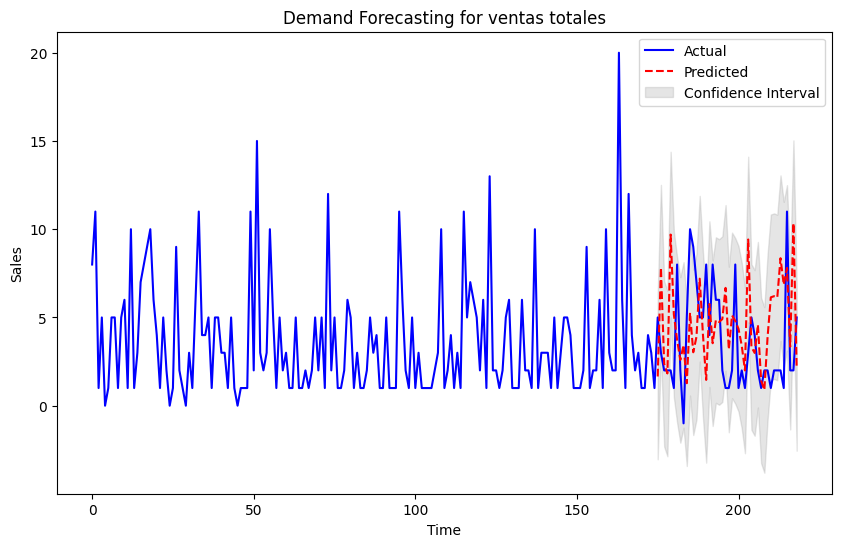

,actual,predicted
180,5.0,1.655049
181,3.0,7.820055
182,2.0,2.374523
183,2.0,1.826264
184,2.0,9.694556


In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Crear características de lag para XGBoost
def create_lag_features(df, lag=3):
    df_lag = pd.DataFrame()
    for i in range(1, lag+1):
        df_lag[f'lag_{i}'] = df.shift(i)
    df_lag['target'] = df
    df_lag.dropna(inplace=True)
    return df_lag

# Crear características de lag
df_lagged = create_lag_features(df_xgboost['cantidad_ventas_producto'], lag=5)

# Separar características y etiquetas
X = df_lagged.drop('target', axis=1)
y = df_lagged['target']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [1000],
    'max_depth': [7],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Configurar Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrenar el modelo final con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Hacer predicciones
y_pred = best_model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostrar métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Crear un DataFrame para comparar los valores reales y predichos
df_forecast = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})

# Combinar los datos históricos con las predicciones
full_series = pd.concat([y_train, y_test])
full_pred_series = pd.concat([pd.Series([np.nan]*len(y_train)), pd.Series(y_pred, index=y_test.index)])

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(full_series.values, label='Actual', color='blue')
plt.plot(full_pred_series.values, label='Predicted', color='red', linestyle='--')
plt.fill_between(range(len(full_pred_series)), 
                 full_pred_series - 2 * np.std(y_pred), 
                 full_pred_series + 2 * np.std(y_pred), 
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title(f'Demand Forecasting for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Mostrar las primeras filas de las predicciones comparadas
df_forecast.head(5)

##### Opción 3

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8}
Mean Squared Error (MSE): 15.166302513068702
Root Mean Squared Error (RMSE): 3.8943937285627275


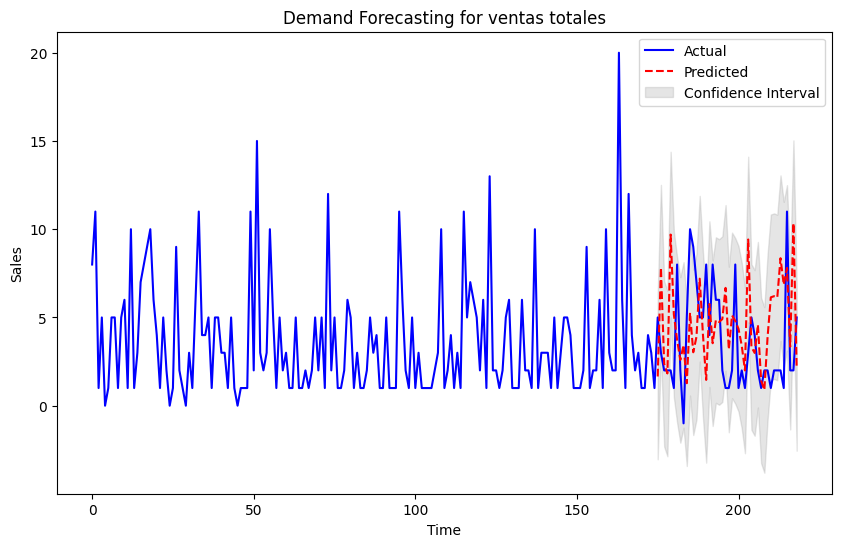

,actual,predicted
180,5.0,1.655049
181,3.0,7.820055
182,2.0,2.374523
183,2.0,1.826264
184,2.0,9.694556


In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

# Asegúrate de que 'df_arima' esté cargado correctamente con las columnas de los productos específicos
column_to_forecast = 'codigo_producto_59'

# Crear características de lag para XGBoost
def create_lag_features(df, lag=3):
    df_lag = pd.DataFrame()
    for i in range(1, lag+1):
        df_lag[f'lag_{i}'] = df.shift(i)
    df_lag['target'] = df
    df_lag.dropna(inplace=True)
    return df_lag

# Crear características de lag
df_lagged = create_lag_features(df_xgboost['cantidad_ventas_producto'], lag=5)

# Separar características y etiquetas
X = df_lagged.drop('target', axis=1)
y = df_lagged['target']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [1000],
    'max_depth': [7],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Configurar Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrenar el modelo final con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Hacer predicciones
y_pred = best_model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostrar métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Crear un DataFrame para comparar los valores reales y predichos
df_forecast = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})

# Combinar los datos históricos con las predicciones
full_series = pd.concat([y_train, y_test])
full_pred_series = pd.concat([pd.Series([np.nan]*len(y_train)), pd.Series(y_pred, index=y_test.index)])

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(full_series.values, label='Actual', color='blue')
plt.plot(full_pred_series.values, label='Predicted', color='red', linestyle='--')
plt.fill_between(range(len(full_pred_series)), 
                 full_pred_series - 2 * np.std(y_pred), 
                 full_pred_series + 2 * np.std(y_pred), 
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title(f'Demand Forecasting for ventas totales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Mostrar las primeras filas de las predicciones comparadas
df_forecast.head(5)